# MNIST Image Classification Using Keras

In [1]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


## Data Import & Preprocessing

由于MNIST数据集的图像尺寸为28x28，且为灰白图像，因此需要先将颜色通道变换出来以方便后面使用。

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train[:, :, :, None]
X_test = X_test[:, :, :, None]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [5]:
nb_classes = 10
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

## Model 1 - 传统神经网络（MLPs）

首先让我们看一下传统多层前馈神经网络（或者称为多层感知器网络）的模型性能。

In [9]:
x = Input(shape=(28, 28, 1))
y = x
y = Flatten()(y)
y = Dense(1024, activation='relu', kernel_initializer='he_normal')(y)
y = Dense(1024, activation='relu', kernel_initializer='he_normal')(y)
y = Dense(nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

model1 = Model(inputs=x, outputs=y, name='MLP')
model1.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10250     
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
_________________________________________________________________


In [10]:
nb_epoch = 50
batch_size = 256
start = time.time()
h = model1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model1.save('MNIST_model_no_data_augmentation.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.3560 - acc: 0.8988 - val_loss: 0.1641 - val_acc: 0.9527
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.1385 - acc: 0.9595 - val_loss: 0.1306 - val_acc: 0.9610
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.0941 - acc: 0.9724 - val_loss: 0.1083 - val_acc: 0.9664
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.0686 - acc: 0.9805 - val_loss: 0.0817 - val_acc: 0.9752
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.0534 - acc: 0.9842 - val_loss: 0.0768 - val_acc: 0.9764
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.0408 - acc: 0.9884 - val_loss: 0.0729 - val_acc: 0.9779
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.0319 - acc: 0.9911 - val_loss: 0.0659 - val_acc: 0.9791
Epoch 8/50
60000/60000 [==============================] - 1s 

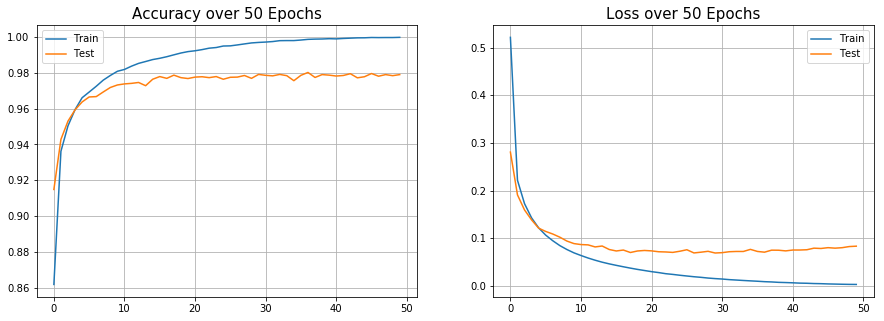

In [8]:
def plot_acc_loss(h, nb_epoch):
    acc, loss, val_acc, val_loss = h.history['acc'], h.history['loss'], h.history['val_acc'], h.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(nb_epoch), acc, label='Train')
    plt.plot(range(nb_epoch), val_acc, label='Test')
    plt.title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(nb_epoch), loss, label='Train')
    plt.plot(range(nb_epoch), val_loss, label='Test')
    plt.title('Loss over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(h, nb_epoch)

### 可以看到，仅仅使用了两个1024节点的全连接层，就可以让模型在测试集上的准确度达到98%，且耗时不到1分钟。

In [11]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 100.00 %     loss = 0.000110
Testing Accuracy = 98.20 %    loss = 0.079164


## Model 2 - 卷积神经网络

现在让我们来看看如果在模型1的前端加上卷积层，效果会如何。这里用的是在CIFAR10数据集能够达到89%准确率的模型
（有一种杀鸡用牛刀的感觉...）

In [8]:
x = Input(shape=(28, 28, 1))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Flatten()(y)
y = Dense(units=128, activation='relu', kernel_initializer='he_normal')(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

model2 = Model(inputs=x, outputs=y, name='model1')
model2.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
__________

In [9]:
nb_epoch = 50
batch_size = 256
start = time.time()
h = model2.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model2.save('MNIST_model_no_data_augmentation_CNN.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s - loss: 0.3775 - acc: 0.8781 - val_loss: 0.0828 - val_acc: 0.9747
Epoch 2/50
60000/60000 [==============================] - 8s - loss: 0.0708 - acc: 0.9795 - val_loss: 0.0432 - val_acc: 0.9854
Epoch 3/50
60000/60000 [==============================] - 8s - loss: 0.0481 - acc: 0.9866 - val_loss: 0.0271 - val_acc: 0.9911
Epoch 4/50
60000/60000 [==============================] - 8s - loss: 0.0348 - acc: 0.9891 - val_loss: 0.0227 - val_acc: 0.9932
Epoch 5/50
60000/60000 [==============================] - 8s - loss: 0.0273 - acc: 0.9921 - val_loss: 0.0208 - val_acc: 0.9926
Epoch 6/50
60000/60000 [==============================] - 8s - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0256 - val_acc: 0.9927
Epoch 7/50
60000/60000 [==============================] - 8s - loss: 0.0184 - acc: 0.9947 - val_loss: 0.0172 - val_acc: 0.9947
Epoch 8/50
60000/60000 [==============================] - 8s 

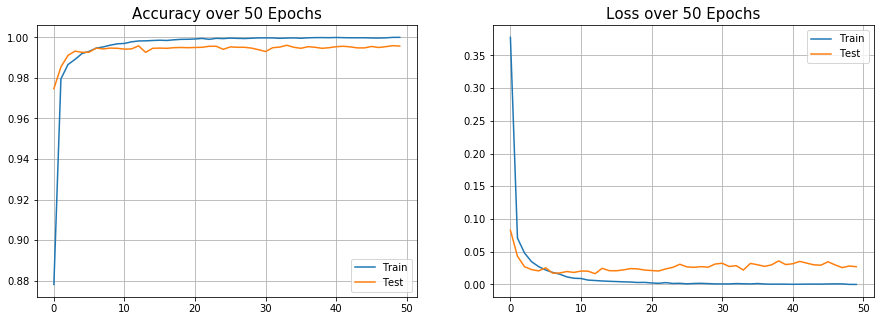

In [11]:
plot_acc_loss(h, nb_epoch)

### 可以看到，使用CNN的模型收敛速度要快的多，经过50代训练，可以达到99.5%的准确率，训练用时460秒。

In [13]:
loss, accuracy = model2.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 100.00 %     loss = 0.000001
Testing Accuracy = 99.57 %    loss = 0.027190


## Visualizations

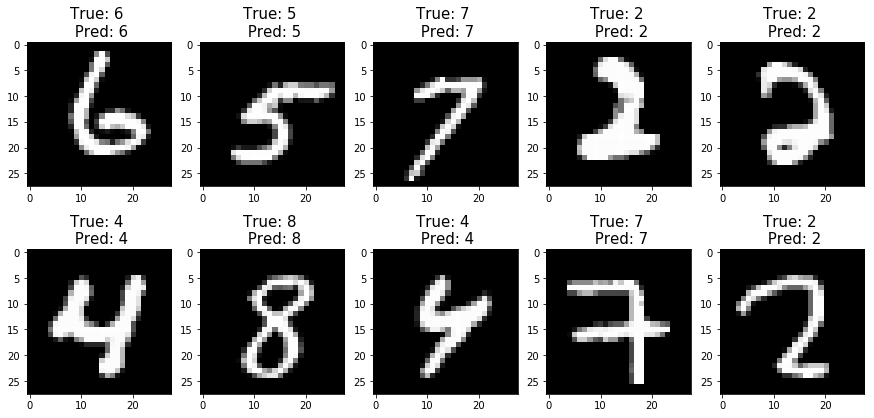

In [17]:
import numpy as np
rand_id = np.random.choice(range(10000), size=10)
X_pred = np.array([X_test[i] for i in rand_id])
y_true = [y_test[i] for i in rand_id]
y_true = np.argmax(y_true, axis=1)
y_pred = model2.predict(X_pred)
y_pred = np.argmax(y_pred, axis=1)
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_pred[i].reshape(28, 28), cmap='gray')
    plt.title('True: %s \n Pred: %s' % (y_true[i], y_pred[i]), size=15)
plt.show()    

## Summary

Model | Accuracy (Train) | Accracy (Test) | Epochs | Time
----  | ----             | ----           | ----   | ---
MLP: FC(1024, 1024) | 100% | 98% | 50  | 56s
Conv (64, 64, 128, 128, 256, 256), FC(128) | 100% | 99.5% | 50 | 460s